# Step 1.2: Examining Discrimination

## Objective

One of the client's requests is to understand whether there is evidence of discrimination against protected classes in past search-and-stop operations. This notebook runs this analysis.

## Findings

By establishing a minumum success-rate difference between protected classes for each station, we concluded that there is evidence in the data for discrimination in most stations. Since this is also the data we will use during training, dealing with this issue will be a significant hurdle to ensure that the model itself does not descriminate.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OrdinalEncoder

# needed to use matplotlib inside jupyter notebook
%matplotlib inline 

In [2]:
# This comes from step 1.1
# List of sattions that have high number of missing values for "Outcome linked to object of search"

outcome_stations_to_drop = ['humberside', 'lancashire', 'metropolitan', 'west-midlands', 'leicestershire']

# List of sattions that have high number of missing values for "Removal of more than just outer clothing"

clothes_stations_to_drop = ['lancashire', 'metropolitan', 'cleveland', 'yorkshire', 'surrey', 'south-yorkshire', 'north-yorkshire']

In [3]:
df_ = pd.read_csv("data/train.csv")

df_.head(10)

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station
0,2e4d0094-c30b-471b-a211-72a9790feca2,Person search,2020-12-01T01:10:00+00:00,NaN,50.798824,-1.089471,Male,25-34,Other ethnic group - Not stated,White,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,Community resolution,False,False,hampshire
1,4779fbe8-6e05-4534-85fd-db32952ee309,Person search,2020-12-01T02:00:00+00:00,NaN,50.785099,-1.091540,Male,over 34,White - Any other White background,Other,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,hampshire
2,cb5c685d-acac-42e2-914d-75e6ff73b0a8,Person search,2020-12-01T09:15:00+00:00,NaN,50.952006,-1.403341,Male,over 34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,True,hampshire
3,f486e116-5b1e-45db-9931-a7f070c5c478,Person search,2020-12-01T10:20:00+00:00,NaN,50.806383,-1.079844,Male,10-17,Other ethnic group - Not stated,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,A no further action disposal,False,False,hampshire
4,78f4020e-12cc-4889-bf1a-2f2c29b2f662,Person search,2020-12-01T10:24:00+00:00,NaN,50.806670,-1.081982,Male,10-17,Other ethnic group - Not stated,Asian,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,A no further action disposal,False,False,hampshire
5,769ac39b-cfe7-4587-855f-b574cdd46933,Person search,2020-12-01T10:30:00+00:00,NaN,50.808359,-1.079465,Male,18-24,Mixed/Multiple ethnic groups - White and Black...,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,Arrest,False,False,hampshire
6,2f3c1b3b-b41a-4b12-b1ab-3c34f93cd20a,Person search,2020-12-01T10:50:00+00:00,NaN,50.914047,-1.401123,Male,over 34,Black/African/Caribbean/Black British - Any ot...,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,True,hampshire
7,b3f957b8-b942-4789-b47c-aa1a6dfcabe7,Person search,2020-12-01T11:00:00+00:00,NaN,50.915304,-1.398959,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,hampshire
8,79807773-d027-4cdf-ad41-531b3bb2cbab,Person search,2020-12-01T11:10:00+00:00,NaN,50.830251,-1.077629,Male,18-24,Black/African/Caribbean/Black British - Caribbean,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution,False,False,hampshire
9,fa5f250a-08f0-411d-85ff-eeaab9659cb5,Person search,2020-12-01T11:10:00+00:00,NaN,50.830251,-1.077629,Male,10-17,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,hampshire


# Analyzing Stop-and-search Discrimination

For this analysis we will remove stations with a low number of Outcome linked to object of search values

In [4]:
# dropping observation_id seen as it doesn't add any relevant information

df_cat = df_.copy().drop(columns='observation_id')

# dropping stations with 0 or very low Outcome linked to object of search values

df_cat = df_cat.loc[~df_cat["station"].isin(outcome_stations_to_drop),:].copy()

# transforming date column

df_cat["Date"] = pd.to_datetime(df_cat["Date"], infer_datetime_format=True, dayfirst=False)

# handle categorical columns

cat_columns = ['Type', 'Gender', 'Self-defined ethnicity', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'Outcome', 'station']

for col in cat_columns:
    df_cat[col] = df_cat[col].astype('category').cat.as_unordered()

# handle ordinal columns

cat_columns = ['Age range']

df_cat['Age range'] = df_cat['Age range'].astype('category').cat.as_ordered().cat.reorder_categories(['under 10', '10-17', '18-24', '25-34', 'over 34'], ordered=True)

# handle boolean columns

bool_columns = ['Part of a policing operation','Outcome linked to object of search','Removal of more than just outer clothing']

for col in bool_columns:
    df_cat[col] = df_cat[col].astype('boolean')

# adding target feature

df_cat['target'] = 0
df_cat.loc[(df_cat["Outcome"]!='A no further action disposal') & (df_cat['Outcome linked to object of search']==True), 'target'] = 1

In [5]:

    
departments = df_cat['station'].unique()
ethnicity_classes = df_cat['Officer-defined ethnicity'].unique()
gender_classes = df_cat['Gender'].unique()

sensitive_classes = [(x,y) for x in ethnicity_classes for y in gender_classes]

department_rates = {}
for department in departments:
    true_rates = {}
    for sensitive_class in sensitive_classes:

        mask = (df_cat['Officer-defined ethnicity'] == sensitive_class[0]) & (df_cat['Gender'] == sensitive_class[1]) & (df_cat['station'] == department)
        
        total = len(df_cat[mask])
        target_true = len(df_cat[mask  & (df_cat['target'] == 1)])
        target_false = len(df_cat[mask  & (df_cat['target'] == 0)])

        # client suggests checking discrimination only for race-gender tuples that have a minimum of 30 samples
        if(total < 30):
            true_rate = np.nan 
        else:
            true_rate = target_true / total

        true_rates[sensitive_class] = true_rate
    department_rates[department] = true_rates

rates = pd.DataFrame.from_dict(department_rates).transpose()
rates["diff"] = rates.max(axis=1).round(5) - rates.min(axis=1).round(5)
rates["worst tuple"] = rates.drop(columns=["diff"]).idxmax(axis=1)
rates["best tuple"] = rates.drop(columns=["diff", "worst tuple"]).idxmin(axis=1)
rates


/var/folders/sj/c0wtvkk15b92vcqw5rhy939r0000gn/T/ipykernel_14842/3764919131.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  rates["worst tuple"] = rates.drop(columns=["diff"]).idxmax(axis=1)
/var/folders/sj/c0wtvkk15b92vcqw5rhy939r0000gn/T/ipykernel_14842/3764919131.py:30: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  rates["best tuple"] = rates.drop(columns=["diff", "worst tuple"]).idxmin(axis=1)


White                         Other                  \
                        Male    Female     Other      Male    Female Other   
hampshire           0.279041  0.254848  0.176991  0.275801  0.260870   NaN   
sussex              0.225583  0.167339       NaN  0.209150       NaN   NaN   
south-yorkshire     0.086349  0.049878       NaN  0.121581       NaN   NaN   
staffordshire       0.195977  0.166667  0.150794  0.105263       NaN   NaN   
bedfordshire        0.208666  0.170576       NaN  0.192308       NaN   NaN   
cumbria             0.223554  0.141860       NaN  0.300000       NaN   NaN   
nottinghamshire     0.252295  0.192857       NaN  0.195876       NaN   NaN   
warwickshire        0.253241  0.219144       NaN  0.269231       NaN   NaN   
devon-and-cornwall  0.185514  0.165077       NaN  0.184211       NaN   NaN   
durham              0.278206  0.274648  0.224490       NaN       NaN   NaN   
thames-valley       0.187496  0.163997       NaN  0.172932       NaN   NaN   
norfolk             0.130515  0.113428  0.078947  0.100000       NaN   NaN   
lincolnshire        0.054427  0.026316       NaN  0.017544       NaN   NaN   
northamptonshire    0.217673  0.189130       NaN       NaN       NaN   NaN   
kent                0.199457  0.195379       NaN  0.143573  0.197183   NaN   
wiltshire           0.195759  0.160714       NaN  0.215686       NaN   NaN   
city-of-london      0.258081  0.266667       NaN  0.239865  0.219512   NaN   
west-mercia         0.259573  0.229660       NaN  0.337662       NaN   NaN   
cheshire            0.233960  0.220482       NaN  0.333333       NaN   NaN   
derbyshire          0.198483  0.200680       NaN  0.177966       NaN   NaN   
btp                 0.188063  0.155349       NaN  0.172581       NaN   NaN   
surrey              0.216527  0.153214       NaN  0.209877       NaN   NaN   
hertfordshire       0.208900  0.152980       NaN  0.200000       NaN   NaN   
north-yorkshire     0.195920  0.167521       NaN       NaN       NaN   NaN   
cambridgeshire      0.236224  0.190323       NaN  0.154762       NaN   NaN   
northumbria         0.219609  0.192162       NaN  0.208955       NaN   NaN   
west-yorkshire      0.169754  0.138715       NaN  0.123506       NaN   NaN   
north-wales         0.181069  0.139785       NaN  0.148796  0.111111   NaN   
cleveland           0.142610  0.145270       NaN  0.169811       NaN   NaN   
gloucestershire     0.201378  0.180401       NaN  0.157434  0.108696   NaN   
avon-and-somerset   0.233612  0.179207       NaN  0.255172       NaN   NaN   
dorset              0.243810  0.187050       NaN       NaN       NaN   NaN   
suffolk             0.189831  0.160323       NaN  0.168919       NaN   NaN   
dyfed-powys         0.033410  0.034965       NaN  0.015385       NaN   NaN   
merseyside          0.153905  0.138280       NaN  0.167715       NaN   NaN   
essex               0.215539  0.158696       NaN  0.183036  0.213333   NaN   

                       Asian                     Black                  \
                        Male    Female Other      Male    Female Other   
hampshire           0.272385  0.195122   NaN  0.250739  0.236842   NaN   
sussex              0.211364       NaN   NaN  0.190959  0.101266   NaN   
south-yorkshire     0.107349  0.080808   NaN  0.114763  0.070796   NaN   
staffordshire       0.205181       NaN   NaN  0.203252  0.208333   NaN   
bedfordshire        0.225749  0.189655   NaN  0.231590  0.127273   NaN   
cumbria             0.272727       NaN   NaN  0.255814       NaN   NaN   
nottinghamshire     0.206579       NaN   NaN  0.213097  0.135135   NaN   
warwickshire        0.272973       NaN   NaN  0.269634       NaN   NaN   
devon-and-cornwall  0.174242       NaN   NaN  0.204433  0.075000   NaN   
durham              0.295455       NaN   NaN       NaN       NaN   NaN   
thames-valley       0.168197  0.170588   NaN  0.178301  0.154270   NaN   
norfolk             0.184713       NaN   NaN  0.177419       NaN   NaN   
lincolnshire        0.

In [6]:
rates.to_csv("results/discrimination_rates.csv")

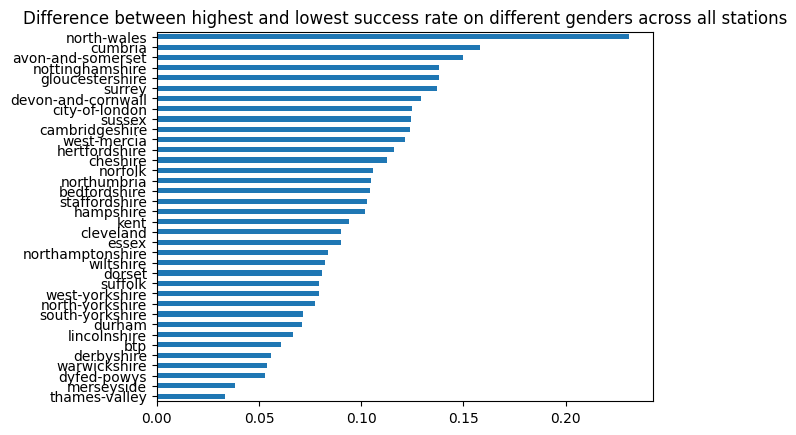

In [7]:
rates.sort_values(by="diff", ascending=True)["diff"].plot.barh()
plt.title("Difference between highest and lowest success rate on different genders across all stations")
plt.show();

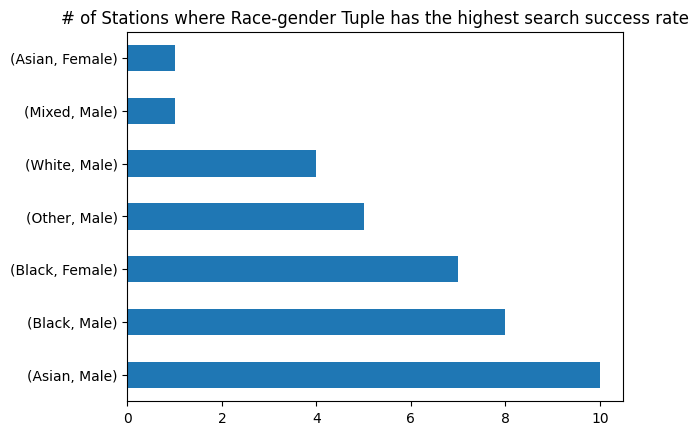

In [8]:
rates["worst tuple"].value_counts().plot.barh()
plt.title("# of Stations where Race-gender Tuple has the highest search success rate")
plt.show();

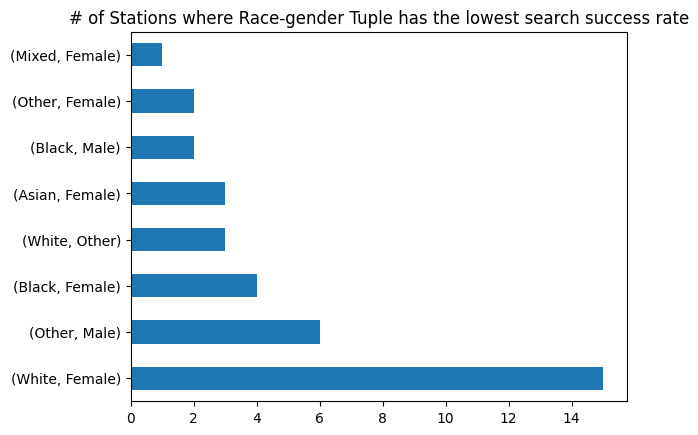

In [9]:
rates["best tuple"].value_counts().plot.barh()
plt.title("# of Stations where Race-gender Tuple has the lowest search success rate")
plt.show();

In [11]:
objectives = df_cat['Object of search'].unique()
ethnicity_classes = df_cat['Officer-defined ethnicity'].unique()
gender_classes = df_cat['Gender'].unique()

sensitive_classes = [(x,y) for x in ethnicity_classes for y in gender_classes]

objective_rates = {}
for objective in objectives:
    true_rates = {}
    for sensitive_class in sensitive_classes:

        mask = (df_cat['Officer-defined ethnicity'] == sensitive_class[0]) & (df_cat['Gender'] == sensitive_class[1]) & (df_cat['Object of search'] == objective)
        
        total = len(df_cat[mask])
        target_true = len(df_cat[mask  & (df_cat['target'] == 1)])
        target_false = len(df_cat[mask  & (df_cat['target'] == 0)])

        # client suggests checking discrimination only for race-gender tuples that have a minimum of 30 samples
        if(total < 30):
            true_rate = np.nan 
        else:
            true_rate = target_true / total

        true_rates[sensitive_class] = true_rate
    objective_rates[objective] = true_rates

rates = pd.DataFrame.from_dict(objective_rates).transpose()
rates["diff"] = rates.max(axis=1).round(5) - rates.min(axis=1).round(5)
rates["worst tuple"] = rates.drop(columns=["diff"]).idxmax(axis=1)
rates["best tuple"] = rates.drop(columns=["diff", "worst tuple"]).idxmin(axis=1)
rates


/var/folders/sj/c0wtvkk15b92vcqw5rhy939r0000gn/T/ipykernel_14842/3575476825.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  rates["worst tuple"] = rates.drop(columns=["diff"]).idxmax(axis=1)
/var/folders/sj/c0wtvkk15b92vcqw5rhy939r0000gn/T/ipykernel_14842/3575476825.py:30: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  rates["best tuple"] = rates.drop(columns=["diff", "worst tuple"]).idxmin(axis=1)


White                      \
                                                    Male    Female     Other   
Article for use in theft                        0.085556  0.094969  0.038462   
Controlled drugs                                0.228597  0.170770  0.214477   
Stolen goods                                    0.169646  0.234661  0.230769   
Offensive weapons                               0.107823  0.083428  0.058824   
Anything to threaten or harm anyone             0.076233  0.052376       NaN   
Articles for use in criminal damage             0.087978  0.086560       NaN   
Firearms                                        0.100053  0.092920       NaN   
Game or poaching equipment                      0.168033       NaN       NaN   
Psychoactive substances                         0.256589  0.178182       NaN   
Fireworks                                       0.039560  0.090909       NaN   
Evidence of offences under the Act              0.115127  0.081081       NaN   
Goods on which duty has not been paid etc.      0.227273       NaN       NaN   
Detailed object of search unavailable           0.046296  0.000000       NaN   
Crossbows                                       0.170213       NaN       NaN   
Evidence of hunting any wild mammal with a dog       NaN       NaN       NaN   
Evidence of wildlife offences                   0.108108       NaN       NaN   
Seals or hunting equipment                           NaN       NaN       NaN   

                                                   Other                  \
                                                    Male    Female Other   
Article for use in theft                        0.099644  0.055556   NaN   
Controlled drugs                                0.214667  0.163636   NaN   
Stolen goods                                    0.165957  0.297297   NaN   
Offensive weapons                               0.108939  0.120000   NaN   
Anything to threaten or harm anyone             0.080000       NaN   NaN   
Articles for use in criminal damage             0.134328       NaN   NaN   
Firearms                                        0.127273       NaN   NaN   
Game or poaching equipment                           NaN       NaN   NaN   
Psychoactive substances                         0.165289       NaN   NaN   
Fireworks                                            NaN       NaN   NaN   
Evidence of offences under the Act              0.118182       NaN   NaN   
Goods on which duty has not been paid etc.           NaN       NaN   NaN   
Detailed object of search unavailable                NaN       NaN   NaN   
Crossbows                                            NaN       NaN   NaN   
Evidence of hunting any wild mammal with a dog       NaN       NaN   NaN   
Evidence of wildlife offences                        NaN       NaN   NaN   
Seals or hunting equipment                           NaN       NaN   NaN   

                                                   Asian                  \
                                                    Male    Female Other   
Article for use in theft                        0.073505  0.093750   NaN   
Controlled drugs                                0.215276  0.186727   NaN   
Stolen goods                                    0.146773  0.194915   NaN   
Offensive weapons                               0.085462  0.082353   NaN   
Anything to threaten or harm anyone             0.059091       NaN   NaN   
Articles for use in criminal damage             0.071895       NaN   NaN   
Firearms                                        0.095238       NaN   NaN   
Game or poaching equipment                           NaN       NaN   NaN   
Psychoactive substances                         0.189516       NaN   NaN   
Fireworks                                       0.080645       NaN   NaN   
Evidence of offences under the Act              0.108571       NaN   NaN   
Goods on which duty has not been paid etc.           NaN       NaN   NaN   
Detailed object of se

In [13]:
rates.to_csv("results/objective_discrimination_rates.csv")

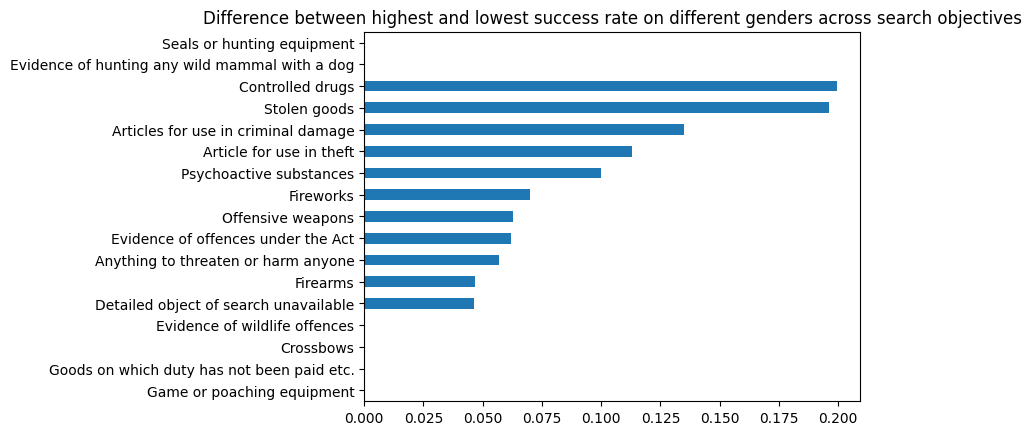

In [14]:
rates.sort_values(by="diff", ascending=True)["diff"].plot.barh()
plt.title("Difference between highest and lowest success rate on different genders across search objectives")
plt.show();

# Analyzing Request for Removal of Clothing Discrimination

For this analysis we will remove the stations with a low number of requests to remove clothing

In [22]:
# dropping observation_id seen as it doesn't add any relevant information

df_cat = df_.copy().drop(columns='observation_id')

# dropping stations with 0 or very low removal of clothing requests values

df_cat = df_cat.loc[~df_cat["station"].isin(clothes_stations_to_drop),:].copy()

# transforming date column

df_cat["Date"] = pd.to_datetime(df_cat["Date"], infer_datetime_format=True, dayfirst=False)

# handle categorical columns

cat_columns = ['Type', 'Gender', 'Self-defined ethnicity', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'Outcome', 'station']

for col in cat_columns:
    df_cat[col] = df_cat[col].astype('category').cat.as_unordered()

# handle ordinal columns

cat_columns = ['Age range']

df_cat['Age range'] = df_cat['Age range'].astype('category').cat.as_ordered().cat.reorder_categories(['under 10', '10-17', '18-24', '25-34', 'over 34'], ordered=True)

# handle boolean columns

bool_columns = ['Part of a policing operation','Outcome linked to object of search','Removal of more than just outer clothing']

for col in bool_columns:
    df_cat[col] = df_cat[col].astype('boolean')

# adding target feature

df_cat['target'] = 0
df_cat.loc[(df_cat["Outcome"]!='A no further action disposal') & (df_cat['Outcome linked to object of search']==True), 'target'] = 1

# fill missing values of 'Removal of more than just outer clothing' with False


print("Before filling")
display(df_cat['Removal of more than just outer clothing'].value_counts(dropna=False))

df_cat.loc[df_cat['Removal of more than just outer clothing'].isna(), 'Removal of more than just outer clothing'] = False

print("After")
display(df_cat['Removal of more than just outer clothing'].value_counts(dropna=False))


Before filling


False    327499
<NA>      18193
True      12253
Name: Removal of more than just outer clothing, dtype: Int64

After


False    345692
True      12253
<NA>          0
Name: Removal of more than just outer clothing, dtype: Int64

In [23]:
departments = df_cat['station'].unique()
ethnicity_classes = df_cat['Officer-defined ethnicity'].unique()
gender_classes = df_cat['Gender'].unique()
age_range_classes = df_cat['Age range'].unique()

sensitive_classes = [(x,y,z) for x in ethnicity_classes for y in gender_classes for z in age_range_classes]

department_rates = {}
for department in departments:
    true_rates = {}
    for sensitive_class in sensitive_classes:

        mask = (df_cat['Officer-defined ethnicity'] == sensitive_class[0]) & (df_cat['Gender'] == sensitive_class[1]) & (df_cat['Age range'] == sensitive_class[2]) & (df_cat['station'] == department)
        
        total = len(df_cat[mask])
        target_true = len(df_cat[mask  & (df_cat['Removal of more than just outer clothing'] == True)])
        target_false = len(df_cat[mask  & (df_cat['Removal of more than just outer clothing'] == False)])

        # client suggests having a 30 sample minimum
        if(total < 30):
            true_rate = np.nan 
        else:
            true_rate = target_true / total

        true_rates[sensitive_class] = true_rate
    department_rates[department] = true_rates

rates = pd.DataFrame.from_dict(department_rates).transpose()
rates["diff"] = rates.max(axis=1).round(5) - rates.min(axis=1).round(5)
rates["worst tuple"] = rates.drop(columns=["diff"]).idxmax(axis=1)
rates["best tuple"] = rates.drop(columns=["diff", "worst tuple"]).idxmin(axis=1)
rates


/var/folders/sj/c0wtvkk15b92vcqw5rhy939r0000gn/T/ipykernel_93489/2091350283.py:30: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  rates["worst tuple"] = rates.drop(columns=["diff"]).idxmax(axis=1)
/var/folders/sj/c0wtvkk15b92vcqw5rhy939r0000gn/T/ipykernel_93489/2091350283.py:31: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  rates["best tuple"] = rates.drop(columns=["diff", "worst tuple"]).idxmin(axis=1)


White                                                   \
                        Male                                           Female   
                       25-34   over 34     10-17     18-24 under 10     25-34   
hampshire           0.035401  0.041334  0.010549  0.030178      NaN  0.060034   
sussex              0.056204  0.040301  0.013699  0.044136      NaN  0.079787   
staffordshire       0.062233  0.051173  0.013080  0.038316      NaN  0.095238   
bedfordshire        0.017544  0.010687  0.013359  0.013350      NaN  0.024000   
cumbria             0.043478  0.039402  0.004237  0.027823      NaN  0.092857   
nottinghamshire     0.025437  0.016842  0.006380  0.033774      NaN  0.021429   
warwickshire        0.046326  0.081538  0.022556  0.034091      NaN  0.102564   
devon-and-cornwall  0.037388  0.043337  0.006618  0.032733      NaN  0.046653   
leicestershire      0.019022  0.021680  0.011208  0.019208      NaN  0.012270   
durham              0.005340  0.002317  0.000000  0.001183      NaN  0.000000   
humberside          0.014736  0.021287  0.006790  0.019100      NaN  0.035714   
thames-valley       0.004587  0.002673  0.002085  0.003366      NaN  0.006319   
norfolk             0.032044  0.050425  0.013283  0.025854      NaN  0.034483   
lincolnshire        0.011102  0.008885  0.000000  0.011728      NaN  0.023669   
northamptonshire    0.022164  0.031722  0.012320  0.024631      NaN  0.051546   
kent                0.018698  0.020328  0.004998  0.014961      NaN  0.032051   
wiltshire           0.069328  0.085714  0.013100  0.052186      NaN  0.061947   
city-of-london      0.045714  0.011673  0.018293  0.026362      NaN  0.031746   
west-mercia         0.040842  0.058252  0.021613  0.040315      NaN  0.056680   
cheshire            0.031934  0.031069  0.001705  0.028744      NaN  0.062802   
derbyshire          0.112224  0.113835  0.019272  0.076705      NaN  0.172840   
btp                 0.021611  0.016651  0.010552  0.021238      NaN  0.019139   
hertfordshire       0.039306  0.040427  0.028846  0.054472      NaN  0.026627   
cambridgeshire      0.036782  0.052521  0.014085  0.037037      NaN  0.145161   
northumbria         0.040816  0.059842  0.058758  0.051447      NaN  0.084746   
west-yorkshire      0.012690  0.015228  0.003988  0.011523      NaN  0.029787   
north-wales         0.036787  0.032484  0.018994  0.040410      NaN  0.032864   
gloucestershire     0.018966  0.024575  0.015094  0.010870      NaN  0.021053   
avon-and-somerset   0.053734  0.051624  0.009198  0.049757      NaN  0.081140   
dorset              0.074236  0.073099  0.014118  0.071429      NaN  0.053191   
suffolk             0.101633  0.088757  0.056940  0.080669      NaN  0.111588   
dyfed-powys         0.029293  0.028446  0.018272  0.020334      NaN  0.047120   
west-midlands       0.013039  0.027112  0.001241  0.016260      NaN  0.000000   
merseyside          0.036129  0.039039  0.009471  0.030600      NaN  0.050532   
essex               0.021718  0.026801  0.011394  0.022063      NaN  0.019608   

                                                                             \
                                                              Other           
                     over 34     10-17     18-24 under 10     25-34 over 34   
hampshire           0.080547  0.002247  0.038095      NaN       NaN     NaN   
sussex              0.069705  0.012195  0.041565      NaN       NaN     NaN   
staffordshire       0.085366  0.000000  0.074074      NaN       NaN     NaN   
bedfordshire        0.020548  0.032787  0.014599      NaN       NaN     NaN   
cumbria             0.073529  0.016949  0.064516      NaN       NaN     NaN   
nottinghamshire     0.015306  0.013889  0.027027      NaN       NaN     NaN   
warwickshire        0.098485  0.000000  0.045872      NaN       NaN     NaN   
devon-and-cornwall  0.082495  0.025210  0.015660      NaN       NaN     NaN   
leicestershire      0.047826  0.000000  0.014925      NaN       NaN     NaN

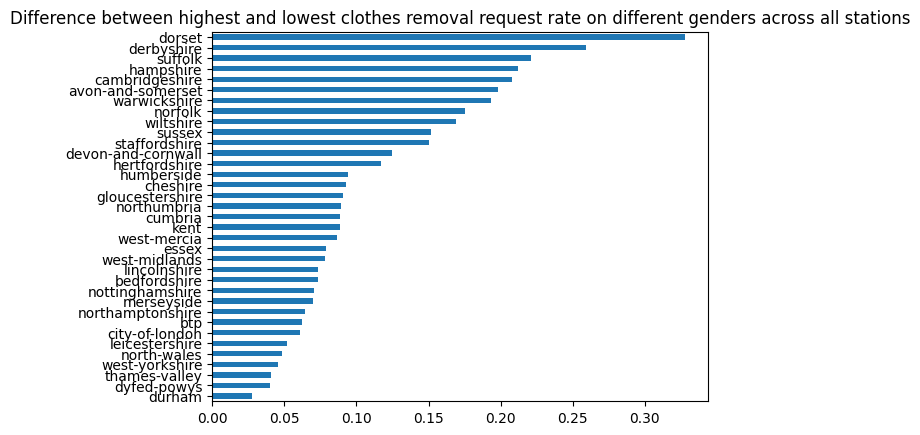

In [24]:
rates.sort_values(by="diff", ascending=True)["diff"].plot.barh()
plt.title("Difference between highest and lowest clothes removal request rate on different genders across all stations")
plt.show();

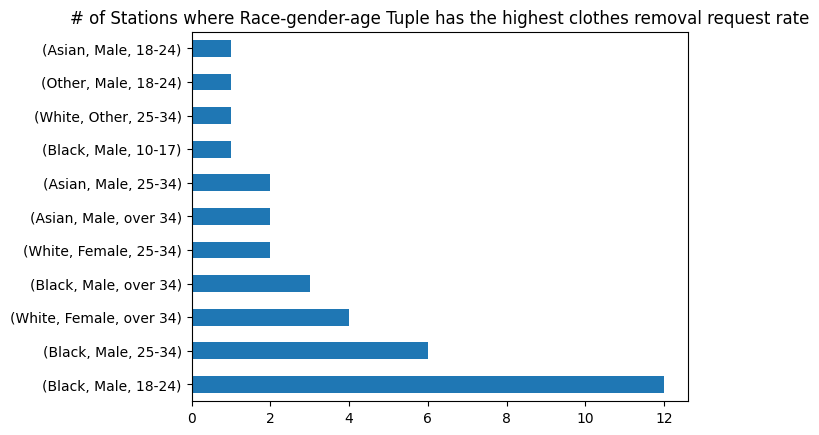

In [25]:
rates["worst tuple"].value_counts().plot.barh()
plt.title("# of Stations where Race-gender-age Tuple has the highest clothes removal request rate")
plt.show();

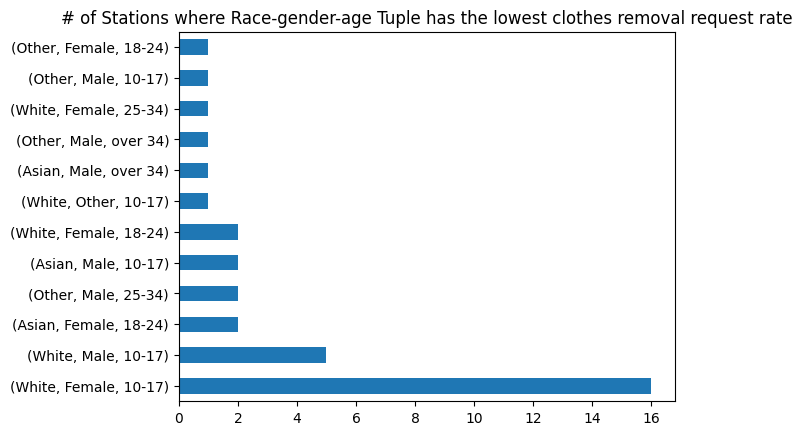

In [26]:
rates["best tuple"].value_counts().plot.barh()
plt.title("# of Stations where Race-gender-age Tuple has the lowest clothes removal request rate")
plt.show();

# Analyzing impact of Requests for removel of Clothing on Search succes

For this analysis we will remove both the stations with a low number of requests to remove clothing and low number of Outcome linked to object of search values

In [27]:
# dropping observation_id seen as it doesn't add any relevant information

df_cat = df_.copy().drop(columns='observation_id')

# dropping stations with 0 or very low removal of clothing requests values

df_cat = df_cat.loc[~df_cat["station"].isin(clothes_stations_to_drop),:].copy()

# also dropping stations with 0 or very low Outcome linked to object of search values

df_cat = df_cat.loc[~df_cat["station"].isin(outcome_stations_to_drop),:].copy()

# transforming date column

df_cat["Date"] = pd.to_datetime(df_cat["Date"], infer_datetime_format=True, dayfirst=False)

# handle categorical columns

cat_columns = ['Type', 'Gender', 'Self-defined ethnicity', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'Outcome', 'station']

for col in cat_columns:
    df_cat[col] = df_cat[col].astype('category').cat.as_unordered()

# handle ordinal columns

cat_columns = ['Age range']

df_cat['Age range'] = df_cat['Age range'].astype('category').cat.as_ordered().cat.reorder_categories(['under 10', '10-17', '18-24', '25-34', 'over 34'], ordered=True)

# handle boolean columns

bool_columns = ['Part of a policing operation','Outcome linked to object of search','Removal of more than just outer clothing']

for col in bool_columns:
    df_cat[col] = df_cat[col].astype('boolean')

# adding target feature

df_cat['target'] = 0
df_cat.loc[(df_cat["Outcome"]!='A no further action disposal') & (df_cat['Outcome linked to object of search']==True), 'target'] = 1

# fill missing values of 'Removal of more than just outer clothing' with False


print("Before filling")
display(df_cat['Removal of more than just outer clothing'].value_counts(dropna=False))

df_cat.loc[df_cat['Removal of more than just outer clothing'].isna(), 'Removal of more than just outer clothing'] = False

print("After")
display(df_cat['Removal of more than just outer clothing'].value_counts(dropna=False))


Before filling


False    300284
<NA>      18173
True      11613
Name: Removal of more than just outer clothing, dtype: Int64

After


False    318457
True      11613
<NA>          0
Name: Removal of more than just outer clothing, dtype: Int64

In [28]:
departments = df_cat['station'].unique()

department_rates = {}

for department in departments:
    

    mask = (df_cat['station'] == department)
    
    total = len(df_cat[mask])
    outcome_true = len(df_cat[mask  & (df_cat['target'] == 1)])
    clothes_true = len(df_cat[mask  & (df_cat['Removal of more than just outer clothing'] == True)])

    # client suggests having a 30 sample minimum
    if(total < 30):
        outcome_rate = np.nan
        clothes_rate = np.nan
    else:
        outcome_rate = outcome_true / total
        clothes_rate = clothes_true / total
        
    department_rates[department] = {"search success rate": outcome_rate, "clothes removal rate":  clothes_rate}

rates = pd.DataFrame.from_dict(department_rates).transpose().sort_values(by="clothes removal rate", ascending=False)
rates

,search success rate,clothes removal rate
derbyshire,0.200643,0.105001
suffolk,0.184357,0.092101
dorset,0.236262,0.077704
avon-and-somerset,0.227690,0.063765
warwickshire,0.251848,0.060158
wiltshire,0.184862,0.058947
staffordshire,0.193384,0.058082
northumbria,0.220189,0.055514
hertfordshire,0.197695,0.055472
sussex,0.212515,0.052470


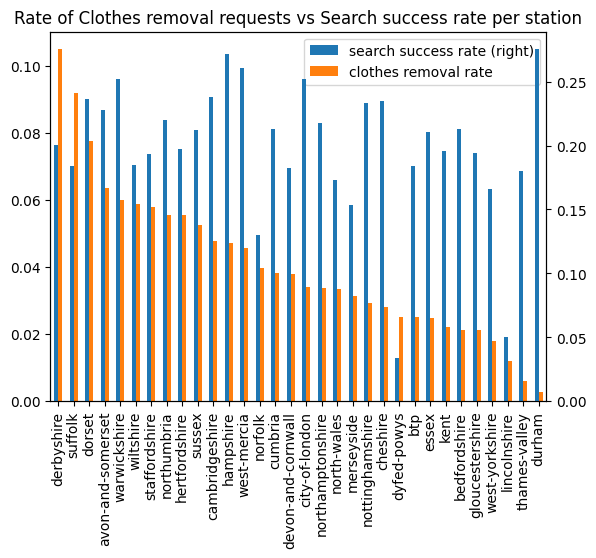

In [29]:
rates.plot( kind= 'bar' , secondary_y= 'search success rate' , rot= 90 )
plt.title("Rate of Clothes removal requests vs Search success rate per station")
plt.show()